In [1]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.1 MB/s eta 0:00:0000:01


In [16]:
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense
from keras import backend as K
class ReadData:
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        
        os.chdir(path)
        os.chdir(subject)
        with open(subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data
        
    def get_labels(self):
        return self.data[self.keys[0]]
    def get_chest_data(self):
        return self.data[self.keys[2]][self.signal_keys[1]]

In [3]:
data_path = '/kaggle/input/tiles-05-05/WESAD'
subject = 'S17'
data_target = {subject: ReadData(data_path, subject)}
chest_data_dict = data_target[subject].get_chest_data()

acc_x = chest_data_dict['ACC'][:, 0]
acc_y = chest_data_dict['ACC'][:, 1]
acc_z = chest_data_dict['ACC'][:, 2]
emg_x = chest_data_dict['EMG'][:, 0]
eda_x = chest_data_dict['EDA'][:, 0]
ecg_x = chest_data_dict['ECG'][:, 0]
temp_x = chest_data_dict['Temp'][:, 0]
resp_x = chest_data_dict['Resp'][:, 0]
w_labels = data_target[subject].data['label']

In [4]:
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values, axis=0), index=df.index, columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    return df_qn
    
df_chest = pd.DataFrame({
    'ACC_X': acc_x,
    'ACC_Y': acc_y,
    'ACC_Z': acc_z,
    'EMG': emg_x,
    'EDA': eda_x,
    'ECG': ecg_x,
    'Temp': temp_x,
    'Resp': resp_x
})
df_chest['w_labels'] = w_labels  

if 'w_labels' in df_chest.columns:
    baseline_0 = df_chest[df_chest['w_labels'] == 0]  
    baseline = df_chest[df_chest['w_labels'] == 1]    
    stress = df_chest[df_chest['w_labels'] == 2]      
    amusement = df_chest[df_chest['w_labels'] == 3]   
else:
    raise KeyError("'w_labels' column not found in df_chest")

df_0 = baseline_0.tail(10000)
df_1 = baseline.tail(10000)
df_2 = stress.tail(10000)
df_3 = amusement.tail(10000)

df_chest = pd.concat([df_3, df_1, df_2, df_0], ignore_index=True)
print("before",df_chest.shape)
print("Before Normalization:")
print(df_chest.describe())

labels_wesad = df_chest.pop('w_labels').to_numpy()
df_chest = quantile_normalize(df_chest)
print("after",df_chest.shape)
print("After Normalization:")
print(df_chest.describe())

before (40000, 9)
Before Normalization:
              ACC_X         ACC_Y         ACC_Z           EMG           EDA  \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean       0.693697     -0.003684     -0.516699     -0.004170      6.546550   
std        0.214727      0.052481      0.293308      0.016550      0.778822   
min        0.354600     -0.148600     -0.914400     -0.183975      5.482864   
25%        0.523450     -0.047800     -0.810000     -0.012497      5.839729   
50%        0.682000      0.006200     -0.519100     -0.003937      6.629562   
75%        0.893000      0.043850     -0.210350      0.004257      7.321930   
max        1.257400      0.153400      0.082600      0.152618      7.411575   

                ECG          Temp          Resp      w_labels  
count  40000.000000  40000.000000  40000.000000  40000.000000  
mean       0.000935     33.891136      0.004522      1.500000  
std        0.304003      0.409040      5.204628      1.1

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Mean Absolute Error (MAE)
def mae_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')  
    return K.mean(K.abs(y_true - y_pred))

def mape_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    diff = K.abs(y_true - y_pred)
    denom = K.maximum(K.abs(y_true), 1.0)  # Use 1.0 instead of tiny epsilon
    return 100.0 * K.mean(diff / denom)

# Root Mean Squared Error (RMSE)
def rmse_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')  
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

x_train shape: (24000, 8, 8, 1), y_train shape: (24000, 4)
x_val shape: (8000, 8, 8, 1), y_val shape: (8000, 4)
x_test shape: (8000, 8, 8, 1), y_test shape: (8000, 4)


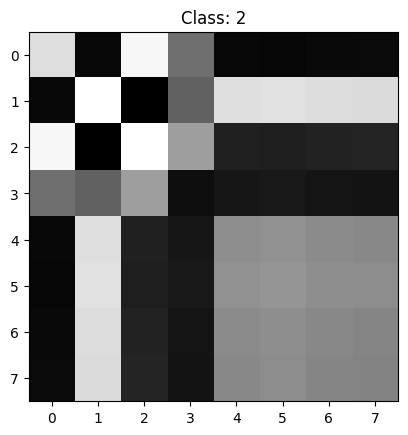

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pyts.image import GramianAngularField

gasf = GramianAngularField(method='summation')

X_train = df_chest.to_numpy()
X_train = gasf.fit_transform(X_train)

Y_train = labels_wesad.reshape(len(labels_wesad), 1)
X_train = X_train.reshape(X_train.shape[0], 8, 8, 1).astype('float32')
X_train /= np.amax(X_train)

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=4)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

plt.imshow(x_train[0, :, :, 0], cmap='gray') 
plt.title(f"Class: {np.argmax(y_train[0])}")
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

# Define the Model with Swish Activation
model_CNN = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), padding="same", kernel_regularizer=regularizers.l2(1e-6), input_shape=(8, 8, 1)),
    layers.BatchNormalization(),
    layers.Activation('swish'),  
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(1e-6)),
    layers.BatchNormalization(),
    layers.Activation('swish'),  
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), padding="same", kernel_regularizer=regularizers.l2(1e-6)),  
    layers.BatchNormalization(),
    layers.Activation('swish'),  
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='swish', kernel_regularizer=regularizers.l2(1e-6)), 
    layers.BatchNormalization(),

    layers.Dense(4, activation='softmax')
])
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_CNN.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=[f1_m,'accuracy', precision_m, recall_m, mae_m, mape_m, rmse_m])
model_CNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,340 (399.77 KB)

 Trainable params: 101,764 (397.52 KB)

 Non-trainable params: 576 (2.25 KB)

In [9]:
model_checkpoint = callbacks.ModelCheckpoint("/kaggle/working/best_model.keras", save_best_only=True, monitor='val_loss', verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model_CNN.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[ model_checkpoint, reduce_lr]
)

Epoch 1/100
746/750 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8100 - f1_m: 0.8015 - loss: 0.7303 - mae_m: 0.1546 - mape_m: 15.4587 - precision_m: 0.8482 - recall_m: 0.7619 - rmse_m: 0.2573
Epoch 1: val_loss improved from inf to 0.61286, saving model to /kaggle/working/best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8103 - f1_m: 0.8019 - loss: 0.7297 - mae_m: 0.1544 - mape_m: 15.4438 - precision_m: 0.8485 - recall_m: 0.7623 - rmse_m: 0.2571 - val_accuracy: 0.8742 - val_f1_m: 0.8690 - val_loss: 0.6129 - val_mae_m: 0.1233 - val_mape_m: 12.3320 - val_precision_m: 0.8992 - val_recall_m: 0.8418 - val_rmse_m: 0.2187 - learning_rate: 0.0010
Epoch 2/100
745/750 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9016 - f1_m: 0.8988 - loss: 0.5499 - mae_m: 0.1072 - mape_m: 10.7250 - precision_m: 0.9258 - recall_m: 0.8741 - rmse_m: 0.1936
Epoch 2: val_loss improved from 0.61286 to 0.55303, saving model to /kaggle/working/best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 

In [10]:
loss, accuracy, f1_score, precision, recall, mae, mape, rmse = model_CNN.evaluate(x_test, y_test, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Validation Loss: 0.4455
Accuracy: 0.9545
F1 Score: 0.9542
Precision: 0.9593
Recall: 0.9500
Mean Absolute Error (MAE): 0.0598
Mean Absolute Percentage Error (MAPE): 5.9788
Root Mean Squared Error (RMSE): 0.1279


**Visualizations**

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Number of test samples: 8000
Number of predictions: 8000
Classes found in test set: [0 1 2 3]

Per-Class Accuracy (Correct Predictions Percentage):
  Class 0: 94.83%
  Class 1: 95.82%
  Class 2: 96.26%
  Class 3: 94.82%

Total Test Accuracy: 95.43%


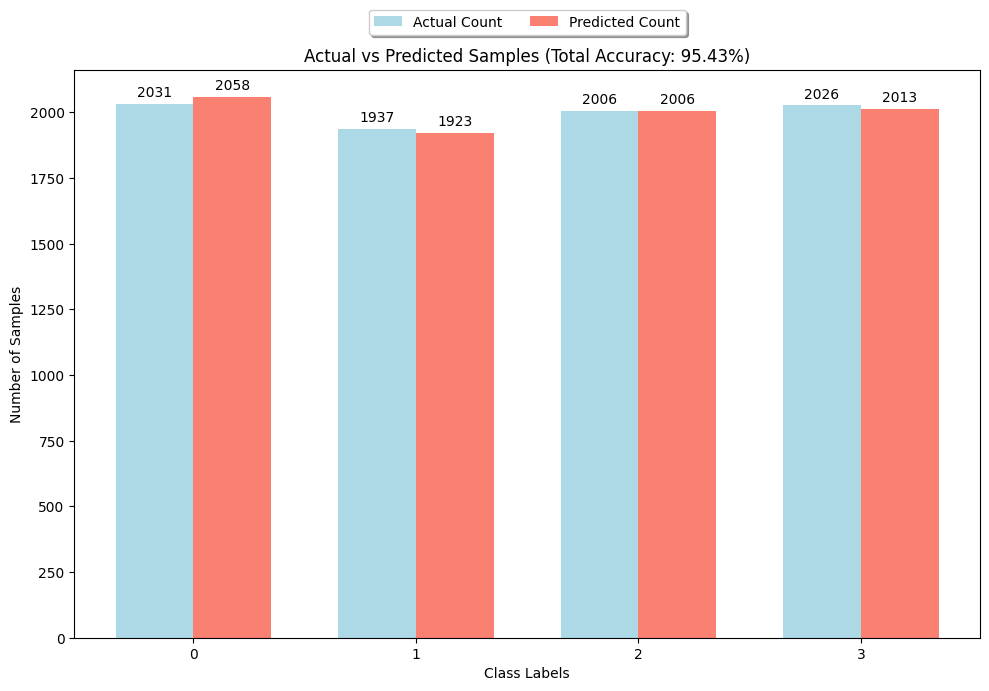

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(model, x_test, y_test):
    # Predict
    y_pred_probs = model.predict(x_test, batch_size=64, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confirm correct number of samples
    print(f"Number of test samples: {len(y_true)}")
    print(f"Number of predictions: {len(y_pred)}")

    if len(y_true) != len(y_pred):
        print("Mismatch between test samples and predictions!")
        return

    # Classes
    classes = np.unique(y_true)
    print(f"Classes found in test set: {classes}")

    # True and Predicted counts
    true_counts = [np.sum(y_true == cls) for cls in classes]
    pred_counts = [np.sum(y_pred == cls) for cls in classes]

    # Correct predictions per class
    correct_counts = [np.sum((y_true == cls) & (y_pred == cls)) for cls in classes]

    # Per-class accuracy (percentage of correct predictions)
    class_accuracy = [
        (correct_counts[i] / true_counts[i]) * 100 if true_counts[i] != 0 else 0
        for i in range(len(classes))
    ]

    # Total accuracy
    total_correct = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    total_accuracy = (total_correct / total_samples) * 100

    # Print per-class accuracy
    print("\nPer-Class Accuracy (Correct Predictions Percentage):")
    for i, acc in enumerate(class_accuracy):
        print(f"  Class {classes[i]}: {acc:.2f}%")
    print(f"\nTotal Test Accuracy: {total_accuracy:.2f}%")

    # Bar plot Actual vs Predicted
    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 7))
    rects1 = ax.bar(x - width/2, true_counts, width, label='Actual Count', color='lightblue')
    rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted Count', color='salmon')

    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Actual vs Predicted Samples (Total Accuracy: {total_accuracy:.2f}%)')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
              ncol=2, fancybox=True, shadow=True)


    # Annotate bar heights
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

# Example usage
plot_actual_vs_predicted(model_CNN, x_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Number of test samples: 8000
Number of predictions: 8000
Classes found in test set: [0 1 2 3]

Per-Class Precision, Recall, F1-Score:
Class 0 -> Precision: 0.9359, Recall: 0.9483, F1-Score: 0.9420
Class 1 -> Precision: 0.9652, Recall: 0.9582, F1-Score: 0.9617
Class 2 -> Precision: 0.9626, Recall: 0.9626, F1-Score: 0.9626
Class 3 -> Precision: 0.9543, Recall: 0.9482, F1-Score: 0.9512


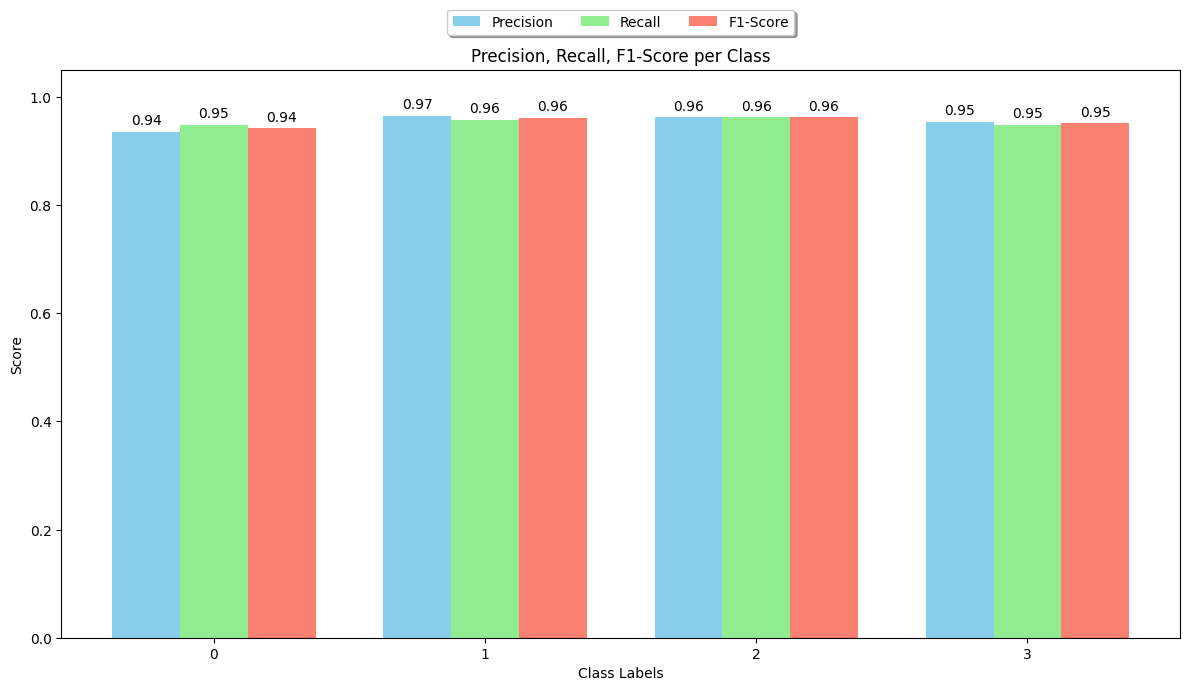

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_precision_recall_f1(model, x_test, y_test):
    # Predict
    y_pred_probs = model.predict(x_test, batch_size=64, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confirm correct number of samples
    print(f"Number of test samples: {len(y_true)}")
    print(f"Number of predictions: {len(y_pred)}")

    if len(y_true) != len(y_pred):
        print("Mismatch between test samples and predictions!")
        return

    # Classes
    classes = np.unique(y_true)
    print(f"Classes found in test set: {classes}")

    # Calculate metrics per class
    precision = precision_score(y_true, y_pred, labels=classes, average=None)
    recall = recall_score(y_true, y_pred, labels=classes, average=None)
    f1 = f1_score(y_true, y_pred, labels=classes, average=None)
       # Print
    print("\nPer-Class Precision, Recall, F1-Score:")
    for idx, cls in enumerate(classes):
        print(f"Class {cls} -> Precision: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}, F1-Score: {f1[idx]:.4f}")

    # Plot
    x = np.arange(len(classes))
    width = 0.25  # bar width

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
    rects2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
    rects3 = ax.bar(x + width, f1, width, label='F1-Score', color='salmon')

    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Score')
    ax.set_title('Precision, Recall, F1-Score per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 1.05)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)
        # Annotate bar heights
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

# Example usage
plot_precision_recall_f1(model_CNN, x_test, y_test)
